/tmp/ipython-input-3-846933754.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


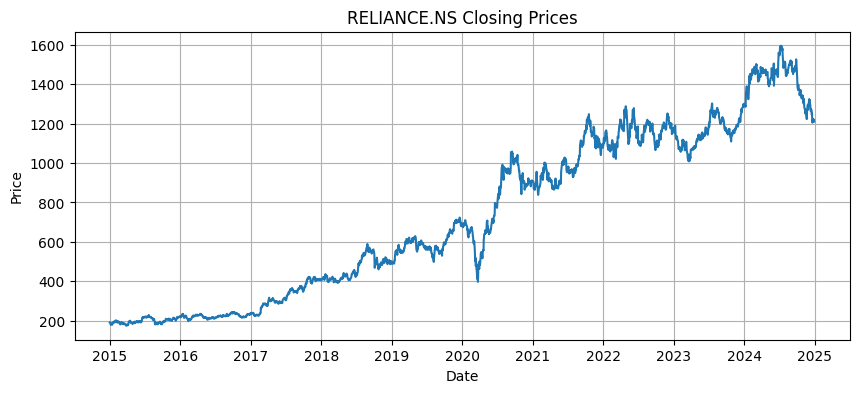

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0323
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 5.5552e-04
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 4.6827e-04
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 5.1155e-04
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 4.7547e-04
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 4.4155e-04
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 4.2222e-04
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 3.7629e-04
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 6.7508e-04
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 4.1209e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


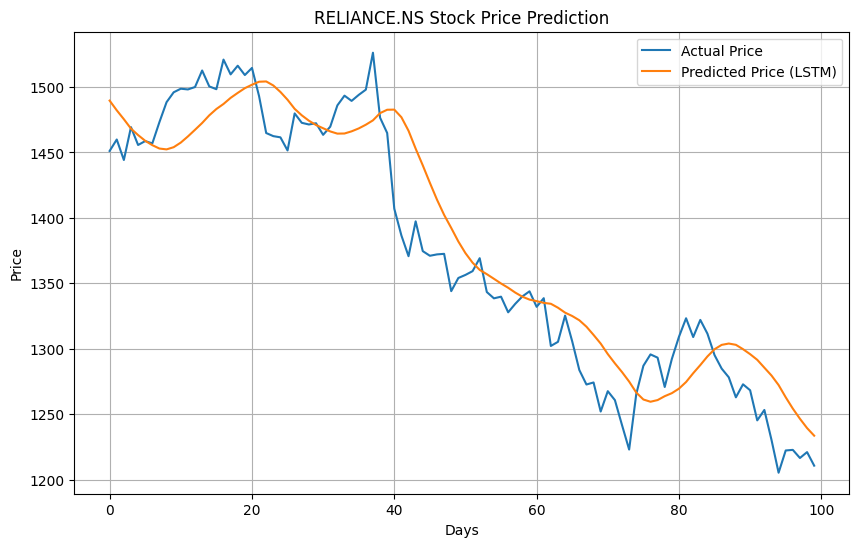

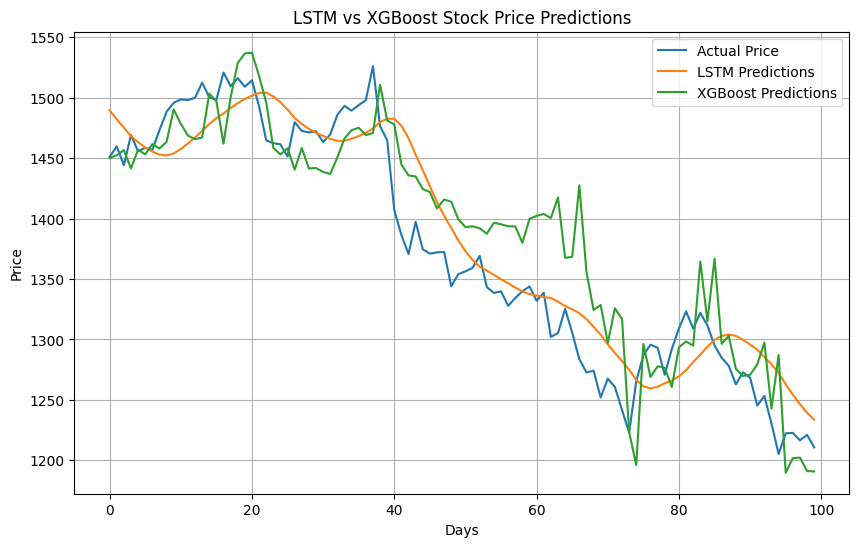

LSTM RMSE: 33.4537
XGBoost RMSE: 43.8615


In [3]:
!pip install yfinance pandas numpy matplotlib scikit-learn keras tensorflow
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Use 'RELIANCE.NS' for NSE, or 'AAPL' for Apple (US)
ticker = 'RELIANCE.NS'

data = yf.download(ticker, start='2015-01-01', end='2024-12-31')
data = data[['Close']]
data.dropna(inplace=True)

plt.figure(figsize=(10,4))
plt.title(f"{ticker} Closing Prices")
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(seq_len, len(data)):
        x.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(x), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

# Train-Test Split (last 100 days for testing)
X_train, X_test = X[:-100], X[-100:]
y_train, y_test = y[:-100], y[-100:]

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predictions
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(real_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price (LSTM)')
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

### XGBoost Model Comparison

# Flatten the data for XGBoost (LSTM uses sequences, XGBoost uses tabular)
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Recreate dataset with tabular features for XGBoost
# Use past 60 days' closing prices as features
def create_xgboost_features(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i].flatten())
        y.append(data[i].flatten()[0])
    return np.array(X), np.array(y)

X_xgb, y_xgb = create_xgboost_features(scaled_data)
X_xgb_train, X_xgb_test = X_xgb[:-100], X_xgb[-100:]
y_xgb_train, y_xgb_test = y_xgb[:-100], y_xgb[-100:]

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_xgb_train, y_xgb_train)

# Predict
xgb_predictions = xgb_model.predict(X_xgb_test).reshape(-1, 1)
xgb_predictions_inv = scaler.inverse_transform(xgb_predictions)
y_xgb_test_inv = scaler.inverse_transform(y_xgb_test.reshape(-1, 1))

# Plot comparison with LSTM (reuse LSTM predictions if available)
plt.figure(figsize=(10, 6))
plt.plot(real_prices, label='Actual Price')
plt.plot(predicted_prices, label='LSTM Predictions')
plt.plot(xgb_predictions_inv, label='XGBoost Predictions')
plt.title('LSTM vs XGBoost Stock Price Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
xgb_rmse = np.sqrt(mean_squared_error(y_xgb_test_inv, xgb_predictions_inv))
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")


